# Lecture 11.3: Deep Neural Networks - Low Light Image Enhancement
We introduce the low-light image enhancement algorithm in "Zero-reference deep curve estimation for low-light image enhancement".

The framework of the zero-reference deep curve estimation (Zero-DCE) is shown in the figure below. A Deep Curve Estimation Network (DCE-Net) is devised to estimate a set of best-fitting Light-Enhancement curves (LE-curves) given an input image. The framework then maps all pixels of the input’s RGB channels by applying the curves iteratively to obtain the final enhanced image.
<img src="framework.png" width="70%">

The LE-curve used in this paper is a quadratic curve, which can be expressed as:

$LE(x) = x+\mathcal{A}(x)x(1- x)$

where $\mathcal{A}$ is a parameter map with the same size as the given image.

The LE-curve defined can be applied iteratively to enable more versatile adjustment to cope with challenging low-light conditions. Specifically,

$LE_{n}(x) = LE_{n-1}(x)+\mathcal{A}_{n}(x) LE_{n-1}(x)(1- LE_{n-1}(x))$

where $n$ is the number of iteration which controls the curvature. This paper sets the value of $n$ to $8$.

First, we need to initialize Python and import the required libraries. Run the below cell.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data as data
import os
import sys
import argparse
import time
from PIL import Image as imaget
import glob
import random
import cv2
from torchvision.models.vgg import vgg16
import numpy as np
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import math
from IPython.display import Image

**Define the dataloder module**.

In [2]:
# dataloader

def populate_train_list(lowlight_images_path):
    image_list_lowlight = glob.glob(lowlight_images_path + "*.jpg") #get the image names
    train_list = image_list_lowlight
    random.shuffle(train_list)

    return train_list

class lowlight_loader(data.Dataset):

    def __init__(self, lowlight_images_path):
        self.train_list = populate_train_list(lowlight_images_path)
        self.size = 256
        self.data_list = self.train_list
        print("Total training examples:", len(self.train_list))

    def __getitem__(self, index):
        data_lowlight_path = self.data_list[index]
        data_lowlight = imaget.open(data_lowlight_path)
        data_lowlight = data_lowlight.resize((self.size,self.size), imaget.ANTIALIAS)
        data_lowlight = (np.asarray(data_lowlight)/255.0)
        data_lowlight = torch.from_numpy(data_lowlight).float()

        return data_lowlight.permute(2,0,1)

    def __len__(self):
        return len(self.data_list)

**Build the network**.
The input to the DCE-Net is a low-light image, while the outputs are a set of pixel-wise curve parameter maps. Instead of employing fully connected layers that require fixed input sizes, They employ a plain CNN of seven convolution layers with symmetrical skip concatenation. In the first six convolution layers, each convolution layer consists of $32$ convolution filters of size $3 \times 3$ and stride $1$ followed by the ReLU activation function. The last convolution layer consists of $24$ convolution kernels of size $3 \times 3$ and stride $1$ followed by the Tanh activation function, which produces $24$ curve parameter maps for eight iterations, where each iteration generates three curve parameter maps for the three channels.
The detailed network architecture and parameter settings of DCE-Net are presented in the figure below.

<img src="DCENet.png" width="50%">



In [3]:
# network
class enhance_net_nopool(nn.Module):
    def __init__(self):
        super(enhance_net_nopool, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        number_f = 32
        self.e_conv1 = nn.Conv2d(3,number_f,3,1,1,bias=True)
        self.e_conv2 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
        self.e_conv3 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
        self.e_conv4 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
        self.e_conv5 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
        self.e_conv6 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
        self.e_conv7 = nn.Conv2d(number_f*2,24,3,1,1,bias=True)
        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)


    def forward(self, x):

        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))

        x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
        r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)


        x = x + r1*(torch.pow(x,2)-x)
        x = x + r2*(torch.pow(x,2)-x)
        x = x + r3*(torch.pow(x,2)-x)
        enhance_image_1 = x + r4*(torch.pow(x,2)-x)
        x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)
        x = x + r6*(torch.pow(x,2)-x)
        x = x + r7*(torch.pow(x,2)-x)
        enhance_image = x + r8*(torch.pow(x,2)-x)
        r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)

        return enhance_image_1,enhance_image,r

This algorithm combines four image quality metrics as the loss function, including spatial consistency loss, exposure control loss, color constancy loss, and illumination smoothness loss, to optimize the network.

The spatial consistency loss $L_{spa}$ encourages spatial coherence of the enhanced image by preserving the difference of neighboring regions between the input image and its enhanced version:

$L_{spa} = \frac{1}{K}\sum_{i=1}^{K}\sum_{j \in \Omega(i)}(\vert(Y_{i}-Y_{j})\vert-\vert(I_{i}-I_{j})\vert)^2$

where $K$ is the number of the local regions, and $\Omega(i)$ is the four neighboring regions (top, down, left, right) centered at the region $i$. We denote $Y_i$ and $I_i$ as the average intensity value of the local region in the enhanced version and input image, respectively.
The figure below illustrates this loss function.

<img src="Lspa.png" width="50%">

The exposure control loss measures the distance between the average intensity value of a local region to the well-exposedness level $E$:

$L_{exp} = \frac{1}{M}\sum_{k=1}^{M}\vert Y_{k}-E \vert$

where $M$ represents the number of nonoverlapping local regions of size $16\times16$, and $E=127$ for an $8$-bit image.

The color constancy loss is to correct the potential color deviations in the enhanced image and also build the relations among the three
adjusted channels:

$L_{cc} = \sum_{\forall (p,q) \in \Omega}(J^{(p)}-J^{(q)})^2, \Omega=\{(R,G),(R,B),(G,B)\}$

where $J^{(p)}$ denotes the average intensity value of the $p$-th channel in the enhanced image, and $(p,q)$ represents a pair of channels.

The illumination smoothness loss is added to each curve parameter map $\mathcal{A}$ to preserve the monotonicity relations between neighboring pixels:

$L_{tv} = \frac{1}{N}\sum_{n=1}^{N}\sum_{c \in \xi }(\vert \nabla_{x}\mathcal{A}_{n}^{c} \vert+\vert \nabla_{y}\mathcal{A}_{n}^{c} \vert), \xi=\{R,G,B\}$

where $N$ is the number of iterations, $\nabla_{x}$ and $\nabla_{y}$ represent the horizontal and vertical gradient operations, respectively.

The total loss can be expressed as:

$L_{total} = L_{spa}+L_{exp}+w_{cc}L_{cc}+w_{tv}L_{tv}$

where $w_{cc}$ and $w_{tv}$ are the weights of the losses.

In [4]:
#loss function

class Loss_color(nn.Module):

    def __init__(self):
        super(Loss_color, self).__init__()

    def forward(self, x ):

        b,c,h,w = x.shape

        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)


        return k


class Loss_spa(nn.Module):

    def __init__(self):
        super(Loss_spa, self).__init__()
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).cuda().unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)

    def forward(self, org , enhance ):
        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)
        enhance_pool = self.pool(enhance_mean)

        weight_diff =torch.max(torch.FloatTensor([1]).cuda() +
                               10000*torch.min(org_pool - torch.FloatTensor([0.3]).cuda(), torch.FloatTensor([0]).cuda()),
                               torch.FloatTensor([0.5]).cuda())
        E_1 = torch.mul(torch.sign(enhance_pool - torch.FloatTensor([0.5]).cuda()) ,enhance_pool-org_pool)


        D_org_letf = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D_left = torch.pow(D_org_letf - D_enhance_letf,2)
        D_right = torch.pow(D_org_right - D_enhance_right,2)
        D_up = torch.pow(D_org_up - D_enhance_up,2)
        D_down = torch.pow(D_org_down - D_enhance_down,2)
        E = (D_left + D_right + D_up +D_down)

        return E

class Loss_exp(nn.Module):

    def __init__(self,patch_size,mean_val):
        super(Loss_exp, self).__init__()
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val
    def forward(self, x ):
        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)
        d = torch.mean(torch.pow(mean- torch.FloatTensor([self.mean_val] ).cuda(),2))
        return d

class Loss_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(Loss_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size


Define the training process.

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def train(config):

    os.environ['CUDA_VISIBLE_DEVICES']='0'
    DCE_net = enhance_net_nopool().cuda()

    DCE_net.apply(weights_init)
    if config.load_pretrain == True:
        DCE_net.load_state_dict(torch.load(config.pretrain_dir))
    #load training data
    train_dataset = lowlight_loader(config.lowlight_images_path)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True,
                                               num_workers=config.num_workers, pin_memory=True)

    L_color = Loss_color()
    L_spa = Loss_spa()
    L_exp = Loss_exp(16,0.6)
    L_TV = Loss_TV()

    # They use ADAM optimizer with default parameters and fixed learning rate 1e−4 for the network optimization
    optimizer = torch.optim.Adam(DCE_net.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    DCE_net.train()

    for epoch in range(config.num_epochs):
        for iteration, img_lowlight in enumerate(train_loader):
            img_lowlight = img_lowlight.cuda()
            enhanced_image_1,enhanced_image,A  = DCE_net(img_lowlight)
            Loss_TV1 = 200*L_TV(A)
            loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))
            loss_col = 5*torch.mean(L_color(enhanced_image))
            loss_exp = 10*torch.mean(L_exp(enhanced_image))
            # best_loss
            loss =  Loss_TV1 + loss_spa + loss_col + loss_exp
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(DCE_net.parameters(),config.grad_clip_norm)
            optimizer.step()
        if ((epoch+1) % config.snapshot_iter) == 0:
            print("Loss at epoch", epoch+1, ":", loss.item())# print loss every config.snapshot_iter epochs and save the weights
            torch.save(DCE_net.state_dict(), config.snapshots_folder + "Epoch" + str(epoch) + '.pth')



Define the input parameters.

In [7]:
if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # Input Parameters
    parser.add_argument('--lowlight_images_path', type=str, default="./data/train_data/")
    parser.add_argument('--lr', type=float, default=0.0001)
    parser.add_argument('--weight_decay', type=float, default=0.0001)
    parser.add_argument('--grad_clip_norm', type=float, default=0.1)
    parser.add_argument('--num_epochs', type=int, default=50)
    parser.add_argument('--train_batch_size', type=int, default=8)
    parser.add_argument('--val_batch_size', type=int, default=4)
    parser.add_argument('--num_workers', type=int, default=0)
    parser.add_argument('--display_iter', type=int, default=10)
    parser.add_argument('--snapshot_iter', type=int, default=10)
    parser.add_argument('--snapshots_folder', type=str, default="./snapshots/")
    parser.add_argument('--load_pretrain', type=bool, default= False)
    parser.add_argument('--pretrain_dir', type=str, default= "./snapshots/Epoch99.pth")

    config = parser.parse_known_args()[0]

    if not os.path.exists(config.snapshots_folder):
        os.mkdir(config.snapshots_folder)
    train(config)

Total training examples: 17


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\HAOYCH~1\AppData\Local\Temp/ipykernel_7716/3853811427.py:43: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(DCE_net.parameters(),config.grad_clip_norm)


Loss at epoch 10 : 1.8442245721817017
Loss at epoch 20 : 1.5173068046569824
Loss at epoch 30 : 1.0792912244796753
Loss at epoch 40 : 0.4712388515472412
Loss at epoch 50 : 1.6058456897735596


Define the testing process.

./data/test_data/LIME\2.bmp


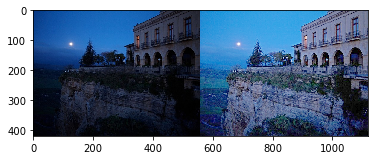

./data/test_data/LIME\9.bmp


C:\Users\haoychen3\Anaconda3\envs\test\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


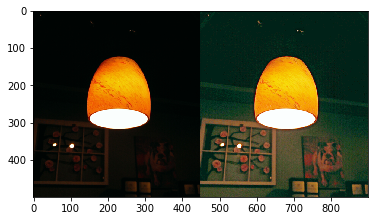

In [8]:
def lowlight(image_path):
    os.environ['CUDA_VISIBLE_DEVICES']='0'
    #load data
    data_lowlight = imaget.open(image_path)
    data_lowlight = (np.asarray(data_lowlight)/255.0)
    data_lowlight = torch.from_numpy(data_lowlight).float()
    data_lowlight = data_lowlight.permute(2,0,1)
    data_lowlight = data_lowlight.cuda().unsqueeze(0)

    DCE_net = enhance_net_nopool().cuda()
    DCE_net.load_state_dict(torch.load('./snapshots/Epoch99.pth')) # load weights
    start = time.time()
    _,enhanced_image,_ = DCE_net(data_lowlight) #enhance the low light images

    image_path = image_path.replace('test_data','result')
    result_path = image_path
    if not os.path.exists(image_path.replace('/'+image_path.split("/")[-1],'')):
        os.makedirs(image_path.replace('/'+image_path.split("/")[-1],''))
    torchvision.utils.save_image(enhanced_image, result_path) # save images
    enhanced_image1 = enhanced_image.permute(0,2,3,1).squeeze().cpu().detach().numpy().astype(np.float32)
    data_lowlight1 = data_lowlight.permute(0,2,3,1).squeeze().cpu().detach().numpy().astype(np.float32)
    show(np.hstack((data_lowlight1, enhanced_image1)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as pl
    pl.figure(figsize=figsize)
    pl.imshow(x, interpolation='nearest')
    if title:
        pl.title(title)
    if cbar:
        pl.colorbar()
    pl.show()

if __name__ == '__main__':
# test_images
    with torch.no_grad():
        filePath = './data/test_data/'

        file_list = os.listdir(filePath)

        for file_name in file_list:
            test_list = glob.glob(filePath+file_name+"/*")
            for image in test_list:
                print(image)
                lowlight(image)
